## Background

Northwind Traders are a US-based company, engaged in the import/export of speciality foods from around the world.  

Despite recent increase in sales, Northwind has recently seen a dramatic reduction in their profitability.  The board at Northwind have therefore asked their data science team to look into the root causes of this issue, and provide recommendations to reverse this worrying trend. 

To help with this task, the board has highlighted the following areas for investigation:

- **Impact of Discounts**: The board has reason to believe that the sales team are making quick sales through the application of discounts, without due regard to the impact on profit margins.  They believe many of the discounts given are not warranted, based on order quantity or value.

- **UK Sales Office**: Three years ago, Northwind Traders opened an office in the UK.  They suspect that this office is not generating sufficient revenue to justify its cost.  

- **Product Categories**: Certain product lines are more successful than others.  Northwind would like to consider rationalising their product lines.  This would reduce investment in slow-moving stock, which is then often written off.

## The Dataset

To complete this task, Northwind have provided access to a number of tables within their database.  These are set out in the schema below.  

A major limitation of this dataset, is that no information on cost price is provided.

![title](Northwind_ERD_updated.png)

## Approach to Investigation

To complete the investigation requested by Northwind, the following approach will be employed:
- Using **Sqlite3** and **Pandas**, data relevant to the investigation will be imported into this Notebook.  
- The data will be preprocessed in order to ensure that there are no missing values or outliers, and that the data is ready to use. 
- Exploratory data analysis will be completed.  This will allow key relationships to be identified.  This will guide the hypothesis tests undertaken.
- Using statsmodels, a number of hypotheses will be tested.  This will isolate any statistically significant relationships, and finally allow for business recommendations to be made.

## Import Libraries Required

Before getting started, all libraries required to complete the investigation are imported.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower
from scipy import stats
from itertools import combinations

## Useful Functions

To prevent the need for repetition of code, the following functions have been defined.  
- **visualise_distributions()**:  This function uses Seaborn to plot the probability density of two populations.
- **hypothesis_t_test()**: This function allows for a two-sided t-test to be performed (Welch's or student's)

In [2]:
# Function to visualise the distributions of each group being compared

def visualise_distributions(population1, population2, parameter_name1, parameter_name2):
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,15)) 
    
    sns.distplot(population1, ax=axes[0][0], color='purple')
    axes[0][0].set_xlabel(parameter_name1)
    axes[0][0].set_ylabel('Probability Density')
    axes[0][0].set_title(f"Probability Distribution: {parameter_name1}")
    
    sns.distplot(population1, ax=axes[0][1], color='green')
    axes[0][1].set_xlabel(parameter_name2)
    axes[0][1].set_ylabel('Probability Density')
    axes[0][1].set_title(f"Probability Distribution: {parameter_name2}")
    
    stats.probplot(population1, plot=axes[1][0])
    axes[1][0].set_title(f"qq-plot: {parameter_name1}")
    
    stats.probplot(population2, plot=axes[1][1])
    axes[1][1].set_title(f"qq-plot: {parameter_name2}")

In [3]:
# Function to perform hypothesis t tests

def hypothesis_t_test(population1, population2, sample_size1, sample_size2, equal_var=True, alpha=0.05, random_state=None):
    
    # Select samples from population
    sample1 = population1.sample(n=sample_size1, random_state=random_state)
    sample2 = population2.sample(n=sample_size2, random_state=random_state)
    
    # Perform two-sample t-test
    t,p = stats.ttest_ind(sample1, sample2, equal_var=equal_var)
    
    # Print t and p values, state whether hypothesis test has been rejected
    if p>alpha:
        return f"The t-statistic is {round(t,2)} with a p-value of {round(p,2)}.  Since the p-value is greater than the cricital level of {alpha} the null hypothesis cannot be rejected"
    else:
        return f"The t-statistic is {round(t,2)} with a p-value of {round(p,2)}.  Since the p-value is less than the cricital level of {alpha}, there is sufficient evidence to reject the null hypothesis."
    

In [4]:
# Create all possible combinations of len(a) and len(b) from items a+b
def combT(a, b):
    union = sorted(a + b)
    all_combs = []
    for x in set(combinations(union, len(a))):
        union_copy = union.copy()
        for y in x:
            union_copy.remove(y)
        all_combs.append((list(x), list(combinations(union_copy, len(union) - len(a)))))
    return all_combs

In [10]:
# Create permutation test
def permutation_test(a,b,alpha):
    # Calculate difference between mean of a and mean of b
    diff_mu_a_b = np.mean(a) - np.mean(b)
    # Compute all possible combinations of len(a) and len(b)
    combos = combT(a, b)
    print("There are {} possible sample variations.".format(len(combos)))
    # Initialise counter
    num = 0
    for ai, bi in combos:
        # calculate difference in means for particular combination
        diff_mu_ai_bi = np.mean(ai) - np.mean(bi)
        # if difference in means for particular combination is greater than diff_mu_a_b, add one to counter
        if diff_mu_ai_bi >= diff_mu_a_b:
            num +=1
    # Compute proportion of times a combination is greater than diff_mu_a_b, add one to counter
    p_val = num / len(combos)
    print('P-value: {}'.format(round((p_val),1)))
    #Accept or recject the null hypothesis
    if (p_val <= alpha):
          print("There is sufficient evidence to reject the null hypothesis")
    else:
          print("This is insufficient evidence to reject the null hypothesis")

In [11]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = round(diff / np.sqrt(pooled_var),1)
    
    if abs(d) <=0.2:
        print(f"Cohen's d is equal to {d}.  The effect size is considered small")
    elif ((abs(d) >0.2) & (abs(d)<=0.8)):
        print(f"Cohen's d is equal to {d}.  The effect size is considered medium")
    else:
        print(f"Cohen's d is equal to {d}.  The effect size is considered large")
    

## Connect to Northwind SQL Database

**sqlite3** is used to execute SQL commands within Python.

In [12]:
# Create connection to database 
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [13]:
# Verify that connection has been correctly established by selecting records from database
c.execute("""SELECT *
                FROM Customer
                LIMIT 5;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


## Create Tables Using sqlite3 and Pandas

### Create Orders Table

At the core of this our analysis is a table containing details on each order, by product.  This will include information about the customer, price/discount applied and sales rep involved.

The table is created by joining the following SQL tables:

- Order
- Customer
- OrderDetail
- Product
- Employee

Pandas is used to format the table into a DataFrame.

In [14]:
# Execute SQL query to extract relevant data
c.execute("""SELECT o.Id AS OrderId, o.OrderDate, o.CustomerId, c.CompanyName AS CustomerName, c.City AS CustomerCity, c.Country AS CustomerCountry,
                    c.Region AS CustomerRegion, od.ProductID, p.ProductName, p.CategoryId, od.UnitPrice AS SalesUnitPrice, 
                    od.Quantity AS SalesQuantity, od.Discount AS SalesDiscount,
                    p.UnitPrice AS ListPrice, 
                    o.EmployeeId, e.LastName AS EmployeeLastName, e.FirstName AS EmployeeFirstName, e.Country AS EmployeeCountry
                FROM 'Order' o
                JOIN Customer c
                ON o.CustomerId = c.Id
                JOIN OrderDetail od
                ON o.Id = od.OrderId
                JOIN Product p
                ON od.ProductId = p.Id
                JOIN Employee e
                ON o.EmployeeId = e.Id
            
                """)

# Convert query results into a DataFrame
orders = pd.DataFrame(c.fetchall())

# Name the columns
orders.columns = [x[0] for x in c.description]

# Display the first 5 rows of the newly created table
orders.head()

,OrderId,OrderDate,CustomerId,CustomerName,CustomerCity,CustomerCountry,CustomerRegion,ProductId,ProductName,CategoryId,SalesUnitPrice,SalesQuantity,SalesDiscount,ListPrice,EmployeeId,EmployeeLastName,EmployeeFirstName,EmployeeCountry
0,10248,2012-07-04,VINET,Vins et alcools Chevalier,Reims,France,Western Europe,11,Queso Cabrales,4,14.0,12,0.0,21.00,5,Buchanan,Steven,UK
1,10248,2012-07-04,VINET,Vins et alcools Chevalier,Reims,France,Western Europe,42,Singaporean Hokkien Fried Mee,5,9.8,10,0.0,14.00,5,Buchanan,Steven,UK
2,10248,2012-07-04,VINET,Vins et alcools Chevalier,Reims,France,Western Europe,72,Mozzarella di Giovanni,4,34.8,5,0.0,34.80,5,Buchanan,Steven,UK
3,10249,2012-07-05,TOMSP,Toms Spezialitäten,Münster,Germany,Western Europe,14,Tofu,7,18.6,9,0.0,23.25,6,Suyama,Michael,UK
4,10249,2012-07-05,TOMSP,Toms Spezialitäten,Münster,Germany,Western Europe,51,Manjimup Dried Apples,7,42.4,40,0.0,53.00,6,Suyama,Michael,UK


### Create Employees Table

A table containing details of employees, their location, and their sales performance is created through the execution of a SQL query.  This SQL query required that a JOIN is performed on the following tables in the Northwind database:

- Employee
- Order
- OrderDetail

In [15]:
c.execute("""SELECT e.Id AS EmployeeId, e.LastName as EmployeeLastName, e.FirstName as EmployeeFirstName, 
                    e.HireDate AS EmployeeHireDate, e.City AS EmployeeCity, e.Region EmployeeRegion, 
                    e.Country AS EmployeeCountry, SUM(od.UnitPrice*od.Quantity) AS TotalSales, 
                    COUNT(od.Id) AS NumberSales
                FROM Employee e
                JOIN 'Order' o
                ON e.Id = o.EmployeeId
                JOIN OrderDetail od
                ON o.Id = od.OrderId
                GROUP BY e.Id
                ORDER BY TotalSales DESC
                    """)
employees = pd.DataFrame(c.fetchall())
employees.columns = [x[0] for x in c.description]
employees


,EmployeeId,EmployeeLastName,EmployeeFirstName,EmployeeHireDate,EmployeeCity,EmployeeRegion,EmployeeCountry,TotalSales,NumberSales
0,4,Peacock,Margaret,2025-05-03,Redmond,North America,USA,250187.45,420
1,3,Leverling,Janet,2024-04-01,Kirkland,North America,USA,213051.30,321
2,1,Davolio,Nancy,2024-05-01,Seattle,North America,USA,202143.71,345
3,2,Fuller,Andrew,2024-08-14,Tacoma,North America,USA,177749.26,241
4,7,King,Robert,2026-01-02,London,British Isles,UK,141295.99,176
5,8,Callahan,Laura,2026-03-05,Seattle,North America,USA,133301.03,260
6,9,Dodsworth,Anne,2026-11-15,London,British Isles,UK,82964.00,107
7,6,Suyama,Michael,2025-10-17,London,British Isles,UK,78198.10,168
8,5,Buchanan,Steven,2025-10-17,London,British Isles,UK,75567.75,117


### Create Products Table 

A products table is created.  This indicates the quantity and value of each product in stock.

In [16]:
# Only columns within products table required
c.execute("""SELECT Id AS ProductID, ProductName, CategoryID, UnitPrice, UnitsInStock, UnitsOnOrder, ReorderLevel, Discontinued
                FROM Product""")
products = pd.DataFrame(c.fetchall())
products.columns = [x[0] for x in c.description]
products.head()

,ProductID,ProductName,CategoryId,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,18.00,39,0,10,0
1,2,Chang,1,19.00,17,40,25,0
2,3,Aniseed Syrup,2,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,21.35,0,0,0,1


## Data Preprocessing

Each table must be cleaned in preparation for statistical analysis.  Crucially, this includes inspecting them for missing data, and dealining with any outliers identified.

### Orders Table

#### Missing Data

To confirm that there is no missing data, the .info() function is used.  This confirms that there are 2078 non-null values in each field.  This suggests that there is no missing data.

In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 18 columns):
OrderId              2078 non-null int64
OrderDate            2078 non-null object
CustomerId           2078 non-null object
CustomerName         2078 non-null object
CustomerCity         2078 non-null object
CustomerCountry      2078 non-null object
CustomerRegion       2078 non-null object
ProductId            2078 non-null int64
ProductName          2078 non-null object
CategoryId           2078 non-null int64
SalesUnitPrice       2078 non-null float64
SalesQuantity        2078 non-null int64
SalesDiscount        2078 non-null float64
ListPrice            2078 non-null float64
EmployeeId           2078 non-null int64
EmployeeLastName     2078 non-null object
EmployeeFirstName    2078 non-null object
EmployeeCountry      2078 non-null object
dtypes: float64(3), int64(5), object(10)
memory usage: 292.3+ KB


#### Outliers

As a starting point, the .describe() function is used in order to detect any outliers.  A visual inspection of this does not present significant cause for concern.  However, it is noted that there is a large difference between the 3rd quartile (32), and the max **SalesUnit Price** (263.5).  Equally, there is a large difference between the 3rd quartile (30) and the max **SalesQuantity** (130).  This will be investigated further, in order to determine whether certain observations should be treated as outliers.

In [18]:
orders.describe()

,OrderId,ProductId,CategoryId,SalesUnitPrice,SalesQuantity,SalesDiscount,ListPrice,EmployeeId
count,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000
mean,10658.376323,40.903754,4.140520,26.277416,23.924447,0.056035,28.006424,4.289702
std,242.371015,22.153715,2.380608,29.962501,19.151339,0.083421,31.621624,2.492705
min,10248.000000,1.000000,1.000000,2.000000,1.000000,0.000000,2.500000,1.000000
25%,10449.000000,22.000000,2.000000,12.000000,10.000000,0.000000,12.500000,2.000000
50%,10656.000000,41.000000,4.000000,18.400000,20.000000,0.000000,19.450000,4.000000
75%,10861.000000,60.000000,6.000000,32.000000,30.000000,0.100000,34.000000,6.000000
max,11077.000000,77.000000,8.000000,263.500000,130.000000,0.250000,263.500000,9.000000


To investigate further, the 10 largest values for both **SalesUnitPrice** and **SalesQuantity** are inspected.

In [19]:
# Print 10 largest values for SalesQuantity
orders['SalesQuantity'].nlargest(10)

1314    130
2043    130
393     120
524     120
684     120
893     120
1093    120
1176    120
1342    120
1631    120
Name: SalesQuantity, dtype: int64

In [20]:
# Print 10 largest values for SalesUnitPrice
orders['SalesUnitPrice'].nlargest(10)

694     263.5
758     263.5
761     263.5
941     263.5
1079    263.5
1354    263.5
1407    263.5
1431    263.5
1434    263.5
1459    263.5
Name: SalesUnitPrice, dtype: float64

Given that there are multiple values assuming the maximum (or close to the maximum), it can be assumed that there are no outliers.

#### Data Engineering: Create New Fields

To complete the analysis, it is anticipated that fields are required to provide the following information:
- A boolean value identifying whether or not a discount has been applied
- A float value that indicates the total value of a product purchased in each order

In [21]:
# Gives a boolean value that indicates whether a discount has been applied or not
orders['DiscountApplied'] = (orders['SalesDiscount'] > 0)

In [22]:
# Provides the total value of an order
orders['SalesTotal'] = orders['SalesUnitPrice'] * orders['SalesQuantity']

### Employees Table

#### Missing Data

Once again, the info() function is used to identify any missing values within the employees table.  This confirms that there are no missing values, and indicates that there are only 9 records within the table.

In [23]:
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 9 columns):
EmployeeId           9 non-null int64
EmployeeLastName     9 non-null object
EmployeeFirstName    9 non-null object
EmployeeHireDate     9 non-null object
EmployeeCity         9 non-null object
EmployeeRegion       9 non-null object
EmployeeCountry      9 non-null object
TotalSales           9 non-null float64
NumberSales          9 non-null int64
dtypes: float64(1), int64(2), object(6)
memory usage: 728.0+ bytes


#### Outliers

Given that there are only 9 records in the employees table, it is possibly to visually inspect the entire table in order to identify any outliers.

In [24]:
employees

,EmployeeId,EmployeeLastName,EmployeeFirstName,EmployeeHireDate,EmployeeCity,EmployeeRegion,EmployeeCountry,TotalSales,NumberSales
0,4,Peacock,Margaret,2025-05-03,Redmond,North America,USA,250187.45,420
1,3,Leverling,Janet,2024-04-01,Kirkland,North America,USA,213051.30,321
2,1,Davolio,Nancy,2024-05-01,Seattle,North America,USA,202143.71,345
3,2,Fuller,Andrew,2024-08-14,Tacoma,North America,USA,177749.26,241
4,7,King,Robert,2026-01-02,London,British Isles,UK,141295.99,176
5,8,Callahan,Laura,2026-03-05,Seattle,North America,USA,133301.03,260
6,9,Dodsworth,Anne,2026-11-15,London,British Isles,UK,82964.00,107
7,6,Suyama,Michael,2025-10-17,London,British Isles,UK,78198.10,168
8,5,Buchanan,Steven,2025-10-17,London,British Isles,UK,75567.75,117


Inspecting the above, there do not seem to be any notable outliers.

However, it is noticeable that the EmployeeHireDate is incorrect.  The Northwind dataset covers a period between 2013 and 2014, all hire dates fall 10+ years later.  As a consequence, it can be determined that this field cannot be used in analysis.  It is therefore dropped.

In [25]:
employees = employees.drop(['EmployeeHireDate'], axis=1)

### Products Table

#### Missing Data

Using the **.info()** function, we can see that there are 77 non-null values in each column.  This suggests that there is no missing data.

In [26]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 8 columns):
ProductID       77 non-null int64
ProductName     77 non-null object
CategoryId      77 non-null int64
UnitPrice       77 non-null float64
UnitsInStock    77 non-null int64
UnitsOnOrder    77 non-null int64
ReorderLevel    77 non-null int64
Discontinued    77 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 4.9+ KB


#### Outliers

To isolate any outliers, the **describe()** function is used.  This does not suggest the presence of any outliers.

In [27]:
products.describe()

,ProductID,CategoryId,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,39.000000,4.116883,28.866364,40.506494,10.129870,12.467532,0.103896
std,22.371857,2.395028,33.815111,36.147222,23.141072,10.931105,0.307127
min,1.000000,1.000000,2.500000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,2.000000,13.250000,15.000000,0.000000,0.000000,0.000000
50%,39.000000,4.000000,19.500000,26.000000,0.000000,10.000000,0.000000
75%,58.000000,6.000000,33.250000,61.000000,0.000000,25.000000,0.000000
max,77.000000,8.000000,263.500000,125.000000,100.000000,30.000000,1.000000


#### Data Engineering: Create New Fields

To provide additional information, a new field is created which gives the total value of stock held for each product.

In [28]:
products['TotalStockValue'] = products['UnitsInStock']*products['UnitPrice']

## Exploratory Data Analysis

Exploratory Data Analysis was performed to:
- Provide additional context to the Northwind business
- Isolate key relationships for investigation

### Sales Trends

Northwind have stated that they have experienced increasing sales over the period under investigation.  To verify this, a line graph showing total sales July 2013 to May 2014 has been generated.  This confirms their assertion.

In [29]:
# Create a new variable for month/year.  This allows orders to be plotted on a monthly basis, instead of daily
orders['month_year'] = pd.to_datetime(orders['OrderDate']).dt.to_period('M')

Text(0, 0.5, 'Total Sales ($)')

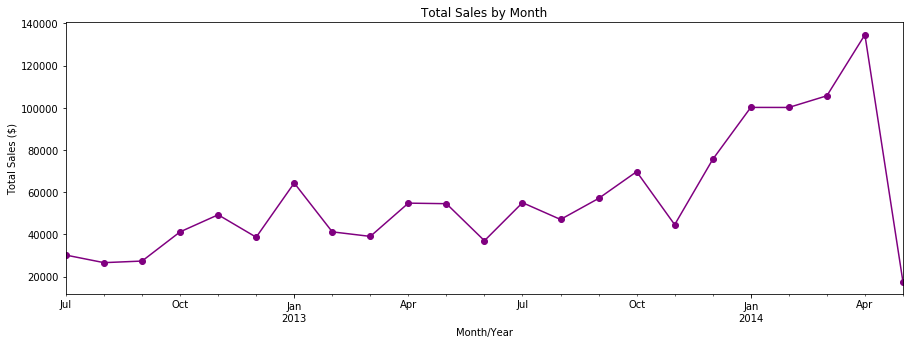

In [30]:
# Create line chart showing total sales v. month
plt.figure(figsize=(15,5))
orders.groupby(['month_year']).sum()['SalesTotal'].plot(color='purple', marker='o')
plt.title('Total Sales by Month')
plt.xlabel('Month/Year')
plt.ylabel('Total Sales ($)')

### Relationship Between Mean Order Quantity, Mean Order Value & Discount

One of the key areas under investigation is the relationship between mean order quantity, meaen order value and discount.  

As a starting point, a graph is plotted showing the mean quantity sold, by product category, for orders with and without a discount.  

**Note:** In a larger study, with more data, it would be preferable to complete this analysis at a product level, rather than a category level.  This is because a customer's responsiveness to discount is likely affected by the product in question.  For example, adding a discount to a perishable food may not increase the quantity ordered.  This is because it must be used/sold within a short period of time.  Conversely, a non-perishable food (e.g. tinned goods), may sell in greater quantities when discounted.

In [31]:
# Create a new dataframe, in which orders are grouped by category, and mean sales quantity and sales value is given
discounts = orders.groupby(['CategoryId','DiscountApplied']).mean().round(0)
discounts.drop(['ProductId','OrderId', 'SalesUnitPrice', 'SalesDiscount', 'ListPrice', 'EmployeeId'], axis=1, inplace=True)

(0, 9)

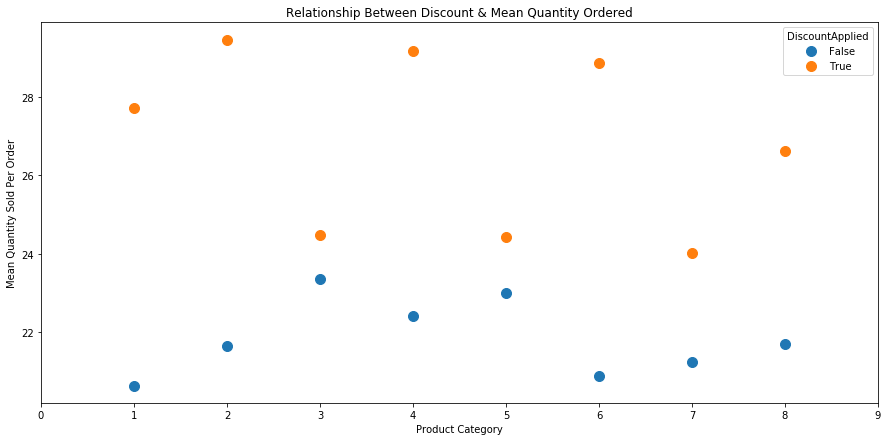

In [32]:
# Create a scatter graph, by category, of mean sales quantity.  This data is divided by discount applied, and not applied
fig, ax = plt.subplots(figsize=(15,7))
orders.groupby(['CategoryId', 'DiscountApplied']).mean()['SalesQuantity'].unstack().plot(ax=ax, marker='o', linestyle='', ms=10)
plt.xlabel('Product Category')
plt.ylabel('Mean Quantity Sold Per Order')
plt.title('Relationship Between Discount & Mean Quantity Ordered')
ax.set_xlim(0,9)

As can be seen in the chart above, mean order quantity does appear to be higher when a discount is applied.  However, without performing a robust statistical test, it is not reasonable to draw a conclusion that discounts to lead to higher order quantities.  It is notable that the scale on the y-axis is from c. 20 to 30.  With this in mind, the difference between order quantities for discounted v. non-discounted orders does not seem large.

(0, 9)

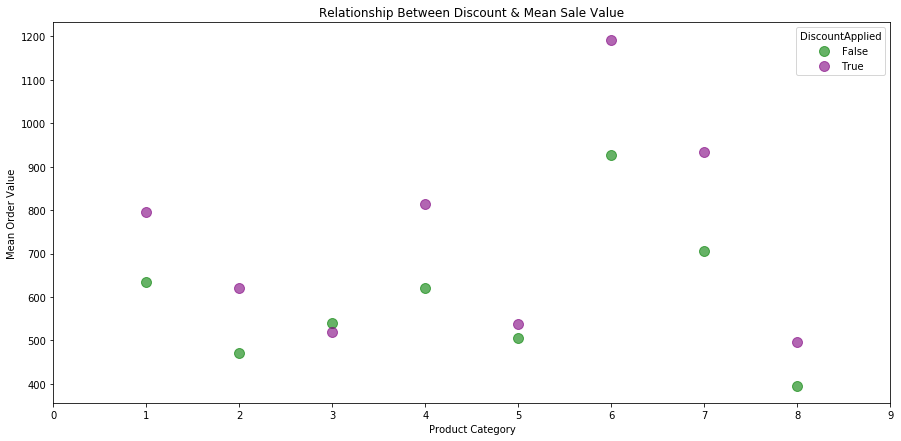

In [33]:
# Create a scatter graph, by category, of mean sales value.  This data is divided by discount applied, and not applied
fig, ax = plt.subplots(figsize=(15,7))
orders.groupby(['CategoryId', 'DiscountApplied']).mean()['SalesTotal'].unstack().plot(ax=ax, marker='o', linestyle='', color=['green', 'purple'], ms=10, alpha=0.6)
plt.xlabel('Product Category')
plt.ylabel('Mean Order Value')
plt.title('Relationship Between Discount & Mean Sale Value')
ax.set_xlim(0,9)

The chart above documents the relationship between category and mean order value, dividing data into discount applied and not applied.  For the majority of categories, it appears that applying a discount increases the mean order value.  Category 3 (desserts/sweets) is the exception to this rule.

To take this analysis a step further, it is wise to visualise the mean order quantity/value by discount amount.  To facilitate this, each order line is put into one of 6 categories: 

- No Discount
- 1-5%
- 6-10%
- 11-15%
- 16-20%
- 21-25%

A bar chart is then shown, indicating the mean order quantity/value for each discount level.

In [34]:
orders['DiscountBins']=pd.cut(x=orders['SalesDiscount'], bins=[-0.0001, 0, 0.05, 0.10, 0.15, 0.2, 0.25], labels=['No Discount', '1-5%', '6-10%', '11-15%', '16-20%', '21-25%'])

Text(0, 0.5, 'Mean Order Quantity')

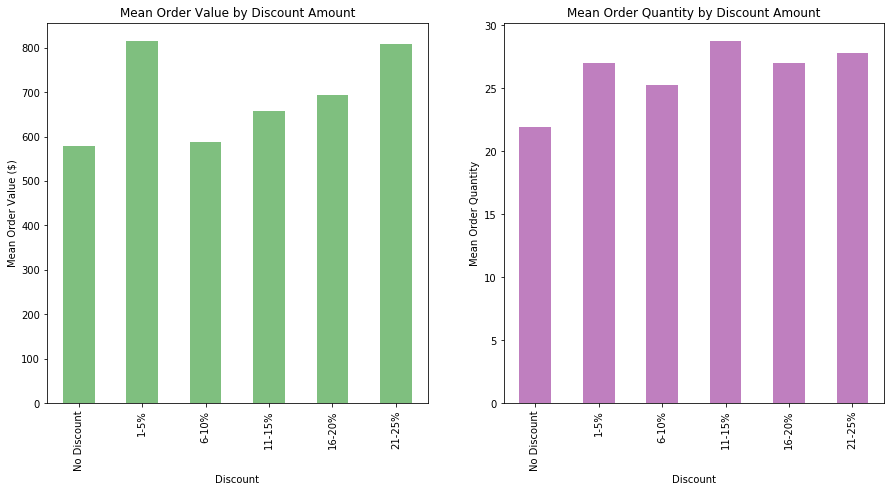

In [35]:
# Create two bar charts to compare mean order value/quantity by discount

# Create figure with 2 axes
fig, (ax1,ax2) = plt.subplots(ncols =2, nrows=1, figsize=(15,7))

# Create dataframe which groups orders by discount level, and then provides mean order value/quantity
df0 = orders.groupby(['DiscountBins']).mean()['SalesTotal']
df1 = orders.groupby(['DiscountBins']).mean()['SalesQuantity']

# Plot mean order value data on ax1
df0.plot.bar(color='green', ax=ax1, alpha=0.5)
ax1.title.set_text('Mean Order Value by Discount Amount')
ax1.set_xlabel('Discount')
ax1.set_ylabel('Mean Order Value ($)')

# Plot mean order value data on ax2
df1.plot.bar(color='purple', ax=ax2, alpha=0.5)
ax2.title.set_text('Mean Order Quantity by Discount Amount')
ax2.set_xlabel('Discount')
ax2.set_ylabel('Mean Order Quantity')


The graph above suggests that a small discount (1-5%) or a large discount (21-25%) has a greater effect on mean  order value than a medium discount.  The effect on mean order quantity appears broadly similar across discount levels.

### Sales Revenue by Employee

Northwind have expressed concern over the performance of their UK Sales Office.  Before completing a hypothesis test, to confirm whether these concerns are valid, the sales performance for each employee is given.

**Note:** Given that the employee hire date field is corrput, it is not possible to ascertain whether poor sales performance can be attributed to being a new employee.  This will need to be investigated further before taking action.

Text(0.5, 1.0, 'Sales Revenue by Employee')

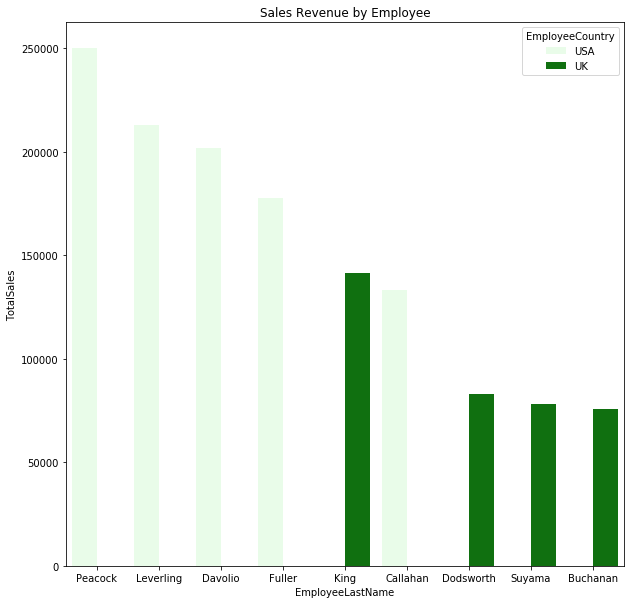

In [36]:
# Create bar charte of total employee sales  by employee, location of each employee is indicated.M
plt.figure(figsize=(10,10))
sns.barplot(employees['EmployeeLastName'], employees['TotalSales'], hue=employees['EmployeeCountry'], color='green')
plt.title('Sales Revenue by Employee')

This graph clearly indicates that the UK employees are under-performing, relative to their US-based colleauges.  This will be investigated further through the application of a hypothesis test.

### Product Category

To understand whether a rationalisation of product lines could help Northwind return to profitability, the total sales and total stock value are plotted.  A low sales value, alongside a high stock value, could indicate a slow moving line.  Northwind should consider culling these products.

Text(0.5, 1.0, 'Sales & Stock Value by Category')

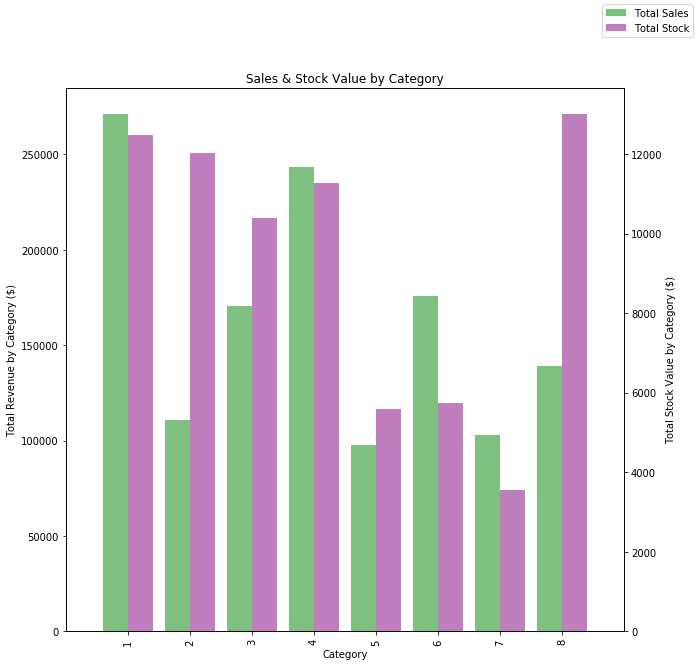

In [37]:
# Create matplotlib figure
fig = plt.figure(figsize=(10,10)) 

# Create matplotlib axes
ax = fig.add_subplot(111) 
ax2 = ax.twinx()

# Isolate x and y values for chart
y_sales = orders.groupby(['CategoryId']).sum()['SalesTotal']
y_stock = products.groupby(['CategoryId']).sum()['TotalStockValue']
x = np.array([1,2,3,4,5,6,7,8])

# Set width of bars
width = 0.4

# Plot bar charts on duplicated axes
y_sales.plot(kind='bar', color='green', ax=ax, width=width, position=1, alpha=0.5, label='Total Sales')
y_stock.plot(kind='bar', color='purple', ax=ax2, width=width, position=0, alpha=0.5, label='Total Stock')

ax.set_ylabel('Total Revenue by Category ($)')
ax2.set_ylabel('Total Stock Value by Category ($)')
ax.set_xlabel('Category')
ax2.set_xlim(-1,8)
fig.legend()
plt.title('Sales & Stock Value by Category')

Category 8 stands out as having a high stock value, relative to sales value.

## Hypothesis Testing

### Does a discount have a statistically significant effect on the quantity of a product in an order? 

Before testing for a difference in mean order quantity, the null and alternative hypothesis must first be stated.  In this case, we are only interested to know whether the presence of a discount **increases** mean order quantity.  As such, a **one-tailed** hypothesis test will be conducted, and the following null and alternative hypotheses are used:

$H_{0}$ : Discount has no statistically significant effect on the quantity of a product in an order 
- $\mu_{discount} \leq \mu_{nodiscount} $

$H_{A}$ : Discount increases the quantity of a product in an order
- $\mu_{discount} \gt \mu_{nodiscount} $

Next, it is necessary to determine the appropriate sample size based on:

- Alpha (equal to the probability of a type 1 error)
- Power (1-power is equal to the probability of type 2 error)
- Effect size

For this hypothesis test, $\alpha$ = 0.05, power=0.9 and effect size = 0.8.  Using this information, the sample size is calculated:

In [38]:
# Calculate desired sample size based on:
# alpha = 0.05, effect size = 0.8, power = 0.9
power_analysis = TTestIndPower()
sample_size = int(power_analysis.solve_power(alpha=0.05, effect_size=0.8, power=0.9))
sample_size

33

33 samples must therefore be selected from each group (orders with discount and orders without discount).  To facilitate this, the orders table is split into two groups, discount and no discount:

In [39]:
# Create populations from which to select samples
quantity_no_discount = orders.loc[orders['DiscountApplied']==False, ['SalesQuantity']]
quantity_with_discount = orders.loc[orders['DiscountApplied']==True, ['SalesQuantity']]

Next, the two groups are be assessed for evidence of normality.  This is achieved using a **distplot**, which shows the distribution of observations, and a **qq-plot**, which compares the distribution of observations to a normal distribution. 

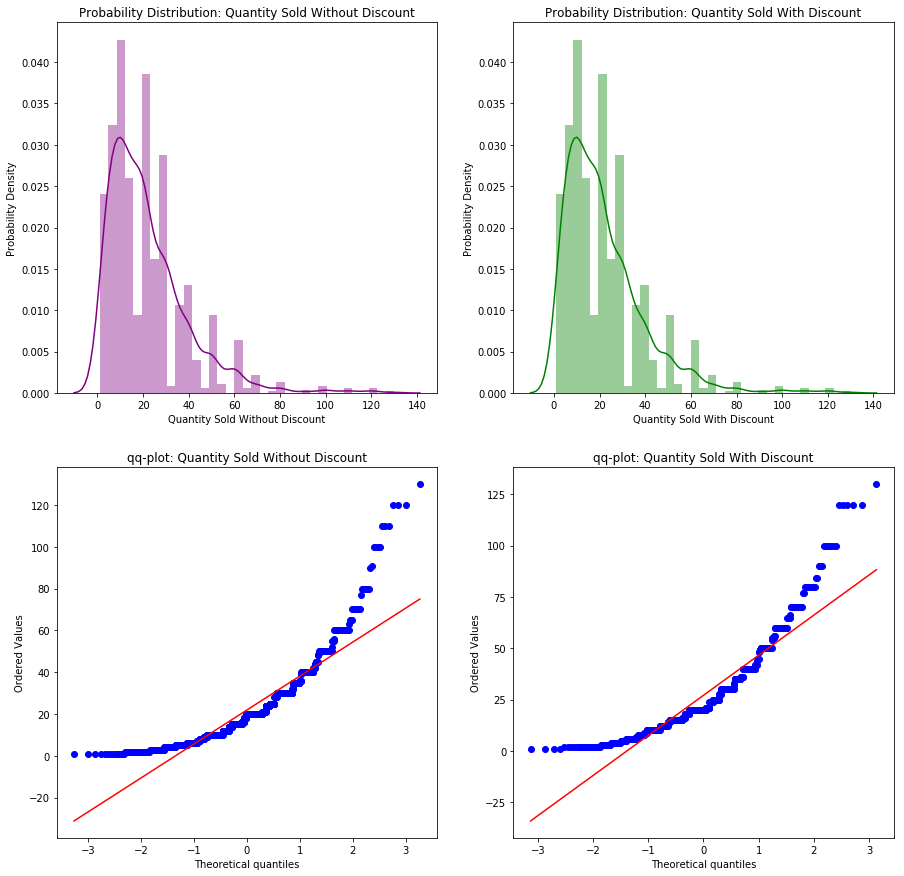

In [40]:
# Check each group for evidence of normality

visualise_distributions(quantity_no_discount['SalesQuantity'], quantity_with_discount['SalesQuantity'], 
                        'Quantity Sold Without Discount', 'Quantity Sold With Discount')


As can be seen from the above, the distribution of observations for both groups is positively skewed.  Whilst it is possible to rely to the Central Limit Theorem, given that n>30, these observations will be transformed using natural logs.  This should improve the normality of the dataset.

In [41]:
# Take logs of each population to improve normality

quantity_no_discount['logSalesQuantity'] = np.log(quantity_no_discount['SalesQuantity'])
quantity_with_discount['logSalesQuantity'] = np.log(quantity_with_discount['SalesQuantity'])


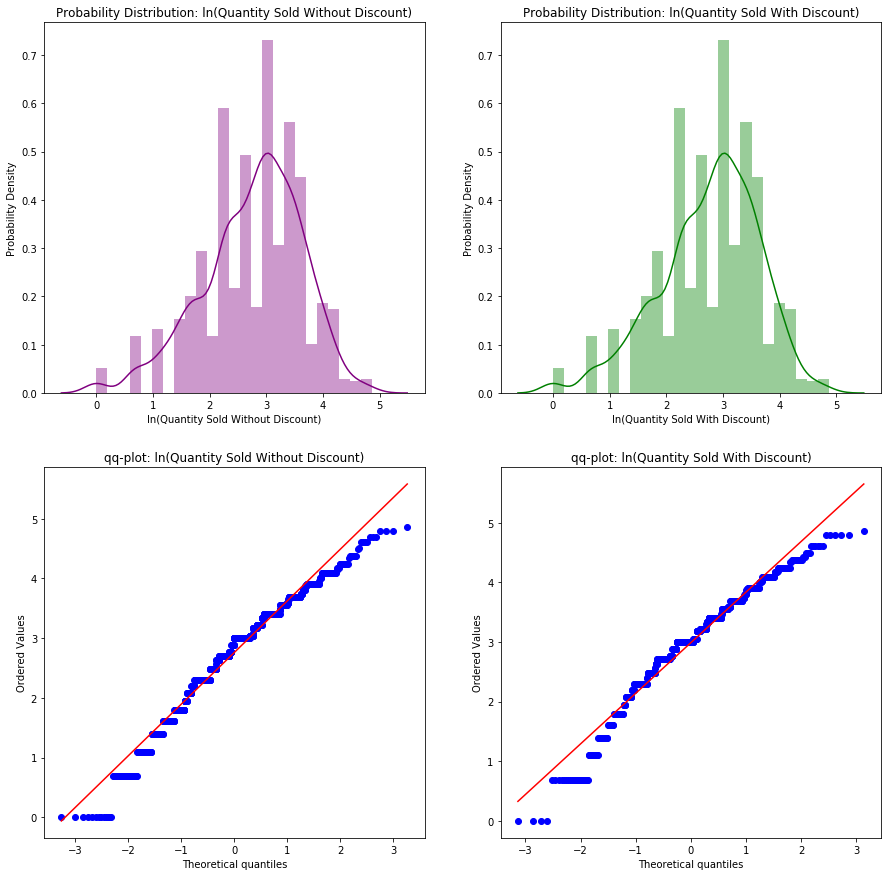

In [42]:
visualise_distributions(quantity_no_discount['logSalesQuantity'], quantity_with_discount['logSalesQuantity'], 
                        'ln(Quantity Sold Without Discount)', 'ln(Quantity Sold With Discount)')

As can be seen, the distributions have a greater degree of normality.  Combined with the Central Limit Theorem, it is reasonable to proceed with this hypothesis test using a 2 sided student's t-test.

Before proceeding with this test, the means of each group are inspected.

In [43]:
# Analyse means from each population
mean_quantity_no_discount = np.mean(quantity_no_discount)
mean_quantity_with_discount = np.mean(quantity_with_discount)
print('Mean Quantity Without Discount: ', round(mean_quantity_no_discount[0],2))
print('Mean Quantity With Discount: ', round(mean_quantity_with_discount[0],2))
print('Difference: ', round((mean_quantity_no_discount-mean_quantity_with_discount)[0],2))


Mean Quantity Without Discount:  21.9
Mean Quantity With Discount:  27.12
Difference:  -5.22


The hypothesis test is now performed:

In [44]:
hypothesis_t_test(quantity_no_discount['logSalesQuantity'], quantity_with_discount['logSalesQuantity'], sample_size, sample_size, random_state=18)

'The t-statistic is -0.53 with a p-value of 0.6.  Since the p-value is greater than the cricital level of 0.05 the null hypothesis cannot be rejected'

Based on the results of the t-test, it is not possible to reject the null hypothesis.  This suggests that discounts do not have a statistically significant effect on mean order quantity.

In [45]:
Cohen_d(quantity_with_discount['SalesQuantity'], quantity_no_discount['SalesQuantity'])

Cohen's d is equal to 0.3.  The effect size is considered medium


### At what levels of discount is there a statistically significant effect?

Next, a more detailed investigastion will take place.  This will consider whether a specific discount percentage yields a difference in mean order quantity.  

This question will be considered for 5 groups, relative to a group in which no discount is given:
- Discount 5%
- Discount 10%
- Discount 15%
- Discount 20%
- Discount 25%

Given that multiple comparisons will be made, a **Bonferroni correction** will be applied to the significant level of 5%.  The Bonferroni correction is used because the risk of a type 1 error increases additively as several comparisons are made.  It is applied by dividing $\alpha$ by the number of comparisons.

In [46]:
# Bonferroni correction - we will be performing 5 comparisons, therefore reduce alpha to 0.01
alpha = 0.05/5

Based on the revised critical value, sample size is calculated.

In [47]:
# Calculate sample size
power_analysis = TTestIndPower()
sample_size = int(power_analysis.solve_power(alpha=alpha, effect_size=0.8, power=0.9))
sample_size

48

Next, a list is created, containing the dataframes relevant to each discount level.

In [48]:
# Create empty list to contain dataframes for each discount level
list_discount_data = []

for discount in [0.00, 0.05, 0.10, 0.15, 0.20, 0.25]:
    # Isolate the orders relating to the specific discount level using .loc
    quantity_x_discount = orders.loc[orders['SalesDiscount']==discount, ['SalesQuantity']]
    # Take logs of Sales Quantity to improvde normality
    quantity_x_discount['logSalesQuantity'] = np.log(quantity_x_discount['SalesQuantity'])
    # Append data to list
    list_discount_data.append(quantity_x_discount)

Finally, the hypothesis tests are run for each discount level, the results are recorded in a table.

In [49]:
hypothesis_test_results = []


for i in range(0, len(list_discount_data)-1):
    discount = (i+1)*5
    no_discount_sample = list_discount_data[0].sample(n=sample_size, random_state=15)
    discount_sample = list_discount_data[i+1].sample(n=sample_size, random_state=17)
    t,p = stats.ttest_ind(no_discount_sample['logSalesQuantity'], discount_sample['logSalesQuantity'])
    hypothesis_test_results.append({'Discount Level (%)': discount, 't-value': round(t,2), 'p-value': round(p,2)})

hypothesis_test_results_df = pd.DataFrame(hypothesis_test_results)
hypothesis_test_results_df

,Discount Level (%),p-value,t-value
0,5,0.87,0.16
1,10,0.86,-0.18
2,15,0.19,-1.31
3,20,0.16,-1.42
4,25,0.04,-2.08


As can be seen from the above, at the 1% significance level, none of the 5 null hypotheses can be rejected.  

### Does discount amount have a statistically significant effect on the mean value an order? 

A natural next step is to consider whether discounts have any statsitically significant effect on the mean value of an order.  If there is no statistically significant effect on the mean value of an order, it suggests that discounts do not increase sales, they only erode profit margin.

Again, a one-tailed test at the 5% significance level will be performed, to ascertain whether discounts increase the mean value of an order.

The null and alternative hypotheses are:

$H_{0}$ : Discount has not statistically significant effect on the average value of an order
- $\mu_{discount} \leq \mu_{nodiscount} $

$H_{1}$ : Discount increases the quantity of the average value of an order
- $\mu_{discount} \gt \mu_{nodiscount} $

First, the population is divided into two groups, according to whether a discount has been applied.

In [50]:
# Create two dataframes, one for each group
quantity_no_discount = orders.loc[orders['DiscountApplied']==False, ['SalesTotal']]
quantity_with_discount = orders.loc[orders['DiscountApplied']==True, ['SalesTotal']]

Next, the distribution of the observations is checked for normality.

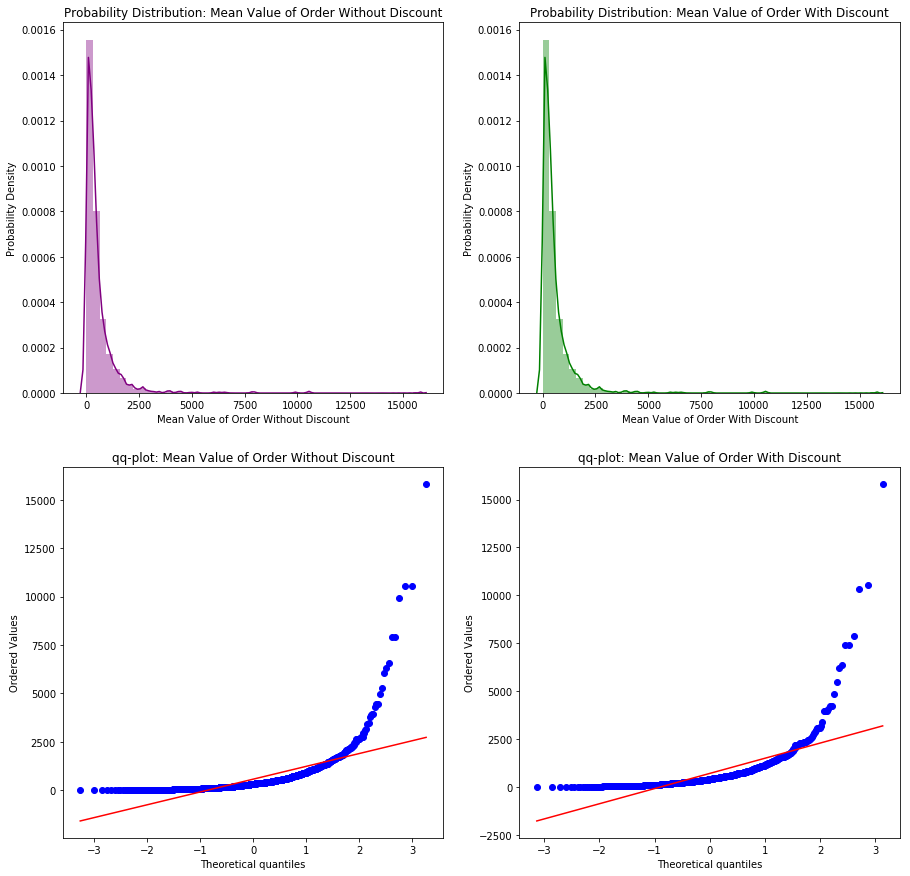

In [51]:
#Visualise the distributions to check for normality
visualise_distributions(quantity_no_discount['SalesTotal'], quantity_with_discount['SalesTotal'], 
                        'Mean Value of Order Without Discount', 'Mean Value of Order With Discount')


Again, the observations do not appear to be normally distributed.  They appear to be positively skewed, with a long tail.  To improve normality, a log transformation is applied.

In [52]:
# Apply log transformation
quantity_no_discount['logSalesTotal'] = np.log(quantity_no_discount['SalesTotal'])
quantity_with_discount['logSalesTotal'] = np.log(quantity_with_discount['SalesTotal'])

Following the log transformation, the distribution of observations is visualised once more.  It appears to closely following a normal distribution.  This fact, alongside the central limit theorem, allows a t-test to be applied.

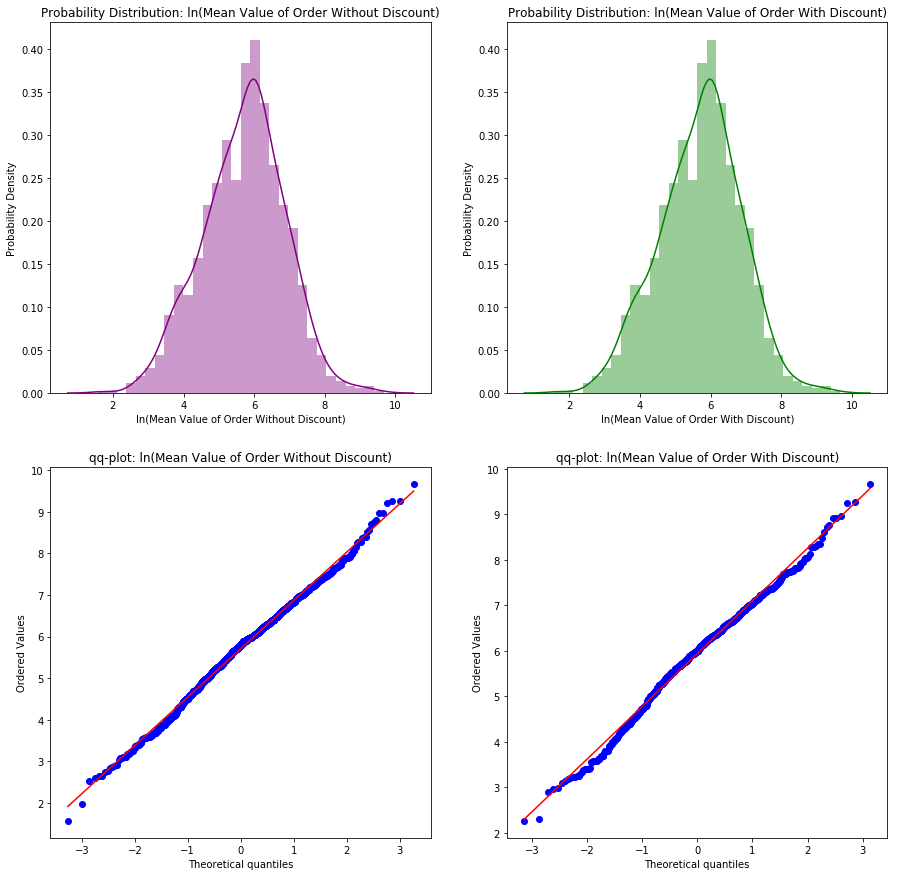

In [53]:
visualise_distributions(quantity_no_discount['logSalesTotal'], quantity_with_discount['logSalesTotal'], 
                        'ln(Mean Value of Order Without Discount)', 'ln(Mean Value of Order With Discount)')

The sample size is then calculated, and a t-test is performed.

In [54]:
# Calculate desired sample size based on:
# alpha = 0.05, effect size = 0.8, power = 0.9
power_analysis = TTestIndPower()
sample_size = int(power_analysis.solve_power(alpha=0.05, effect_size=0.8, power=0.9))
sample_size

33

In [55]:
hypothesis_t_test(quantity_no_discount['logSalesTotal'], quantity_with_discount['logSalesTotal'], sample_size, sample_size, random_state=22)



'The t-statistic is -0.3 with a p-value of 0.77.  Since the p-value is greater than the cricital level of 0.05 the null hypothesis cannot be rejected'

There is therefore insufficient evidence to suggest that the application of a discount affects mean value of an order. 

### Does Employee Location have a statistically significant effect on sales performance?

Northwind has reason to believe that staff in their UK Sales Office are under-performing relative to staff in their US Sales Office.  To investigate this claim, a hypothesis test is run to determine whether location has any effect on sales performance of an employee.

$H_{0}$ : Location has no effect on sales performance of an employee:
- $\mu_{uk} = \mu_{usa}$

$H_{1}$ : Location has an effect on the sales performance of an employee
- $\mu_{uk} \neq \mu_{usa}$

This is a two-tailed test (i.e. we are looking for differences that suggest the sales performance of the UK is either greater or less than that of the US).  

Again, the test will operate at the 5% significance level.  However, since this is two tailed, the p-value obtained will need to be less than 2.5% if the null hypothesis is to be rejected.

Before performing a hypothesis test, data from the employees table is split by employee country (UK or USA).  

In [56]:
uk_total_sales = employees.loc[employees['EmployeeCountry']=='UK']
usa_total_sales = employees.loc[employees['EmployeeCountry']=='USA']

The number of observations, mean and standard deviation for each group is calculated.

In [57]:
location_dict = []
for key, val in {'UK':uk_total_sales['TotalSales'], 'USA': usa_total_sales['TotalSales']}.items():
    mean = round(np.mean(val),2)
    std = round(np.std(val),2)
    nobs = len(val)
    location_dict.append({'Location':key, 'Mean':mean, 'Std':std, 'Number_Obs':nobs})

location_df = pd.DataFrame(location_dict)
location_df

,Location,Mean,Number_Obs,Std
0,UK,94506.46,4,27143.72
1,USA,195286.55,5,38798.14


What is noticeable from the above, is that there are very few observations.  It will therefore not be possible to apply the central limit theorem, and make an assumption of normality, in order to perform the t-test.  Instead, a non-parametric permutation test will be used to test the null hypothesis.

A permutation test compares the difference between the sample means, to the difference in sample means between all combinations the datapoints.  The p-value is then calculated by determining the proportion of times the difference in sample means between a particular combination exceeds the difference between the actual sample means.  

To do this, the permutation function created at the start of this notebook will be used.

In [58]:
permutation_test(list(usa_total_sales['TotalSales']),list(uk_total_sales['TotalSales']),0.05)

There are 126 possible sample variations.
P-value: 0.0
There is sufficient evidence to reject the null hypothesis


In [59]:
permutation_test([9], [1,3], 0.05)

There are 3 possible sample variations.
P-value: 0.3
This is insufficient evidence to reject the null hypothesis


Applying this permutation test, there is sufficient evidence to reject the null hypothesis.  This suggests that the UK employees are under-performing.  Northwind will need to consider whether their UK office remains economically viable.

As a point of interest, a Welch's t-test is also performed (**Note** the assumption of normality has not been satisfied, so findings should be treated with caution).  This also leads to the rejection of the null hypothesis.  

In [60]:
hypothesis_t_test(uk_total_sales['TotalSales'], usa_total_sales['TotalSales'], len(uk_total_sales), len(usa_total_sales), equal_var = False)



'The t-statistic is -4.04 with a p-value of 0.0.  Since the p-value is less than the cricital level of 0.05, there is sufficient evidence to reject the null hypothesis.'

Given that the null hypothesis has been rejected.  It is appropriate to calculate effect size.  Effect size provides a standardised way of interpreting the scale of difference between two groups.  In this case, Cohen's d will be used to calculate effect size.

Cohen's d is calculated as:

- $d$ = effect size (difference of means) / pooled standard deviation

The formula has been built into a function **Cohen_d()** (see useful functions section).  It is therefore applied now.

In [61]:
Cohen_d(usa_total_sales['TotalSales'], uk_total_sales['TotalSales'])

Cohen's d is equal to 2.6.  The effect size is considered large


Generally speaking, if $d$ is greater than 0.8, the effect can be considered large.  Given that the value here is 2.6, the effect of location on employee sales performance cannot be ignored.

### Does Product Category have a statistically significant effect on mean sales value?

Finally, a hypothesis test is run to determine whether product category has a significant effect on mean sales value.   Specificically, we are looking to determine whether a product belonging to category 8 (fish products), is likely to have a lower mean sales value than those belonging to other categories.

This test is being performed because, during EDA, it was noted that the stock value of category 8 products was much higher than total sales over the 2013-14 period.  There may therefore be reason to discontinue fish products, to avoid the write-off of slow miving stock.  

$H_{0}$ : There is no statsticially significant difference in mean sales value of category 8 products versus products from other categories

- $\mu_{cat8} = \mu_{non-cat8}$

$H_{1}$ : There is a statsticially significant difference in mean sales value of category 8 products versus products from other categories

- $\mu_{cat8} \neq \mu_{non-cat8}$

This two-tailed test will be performed at the 5% significance level.

First, the population is split into category 8 and non-category 8 orders.

In [62]:
cat_8_sales = orders.loc[orders['CategoryId']==8, ['SalesTotal']]
all_other_sales = orders.loc[orders['CategoryId']!=8, ['SalesTotal']]

Then, the sample size is calculated.

In [63]:
# Calculate desired sample size based on:
# alpha = 0.05, effect size = 0.8, power = 0.9
power_analysis = TTestIndPower()
sample_size = int(power_analysis.solve_power(alpha=0.05, effect_size=0.8, power=0.9))
sample_size

33

Next, the data is checked for normality.

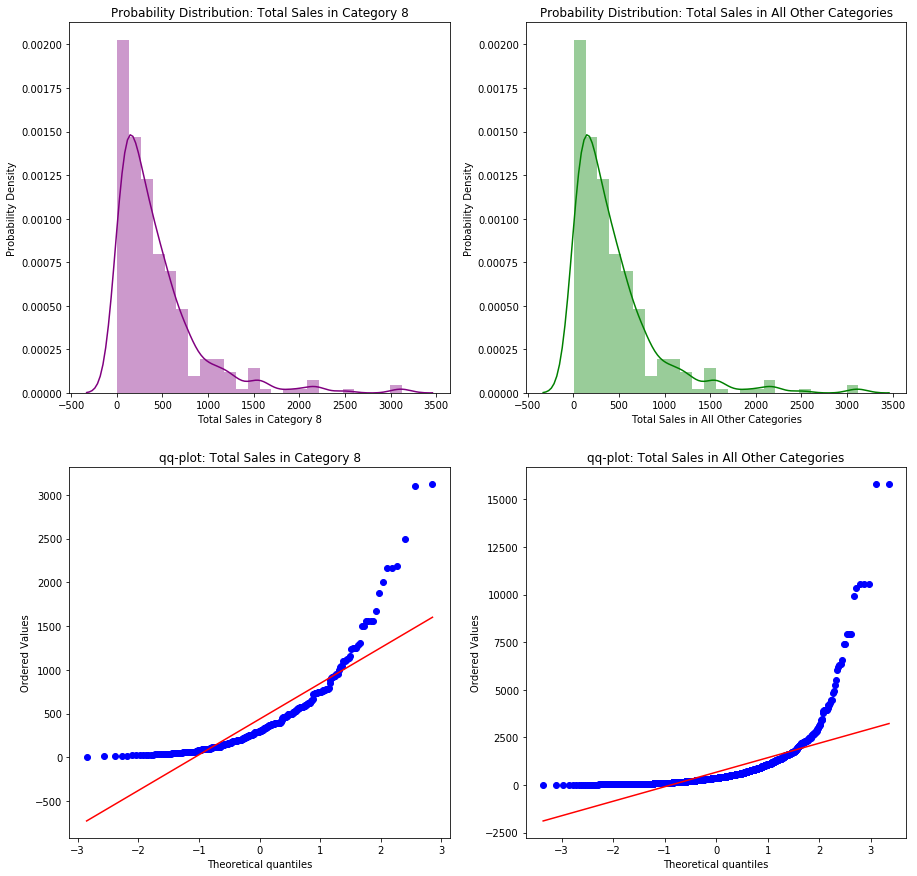

In [64]:
# Check normality of data
visualise_distributions(cat_8_sales['SalesTotal'], all_other_sales['SalesTotal'], 'Total Sales in Category 8', 
                        'Total Sales in All Other Categories')

Again, the distribution is positively skewed, and non-normal.  A log transformation is applied.

In [65]:
cat_8_sales['logSalesTotal'] = np.log(cat_8_sales['SalesTotal'])
all_other_sales['logSalesTotal'] = np.log(all_other_sales['SalesTotal'])

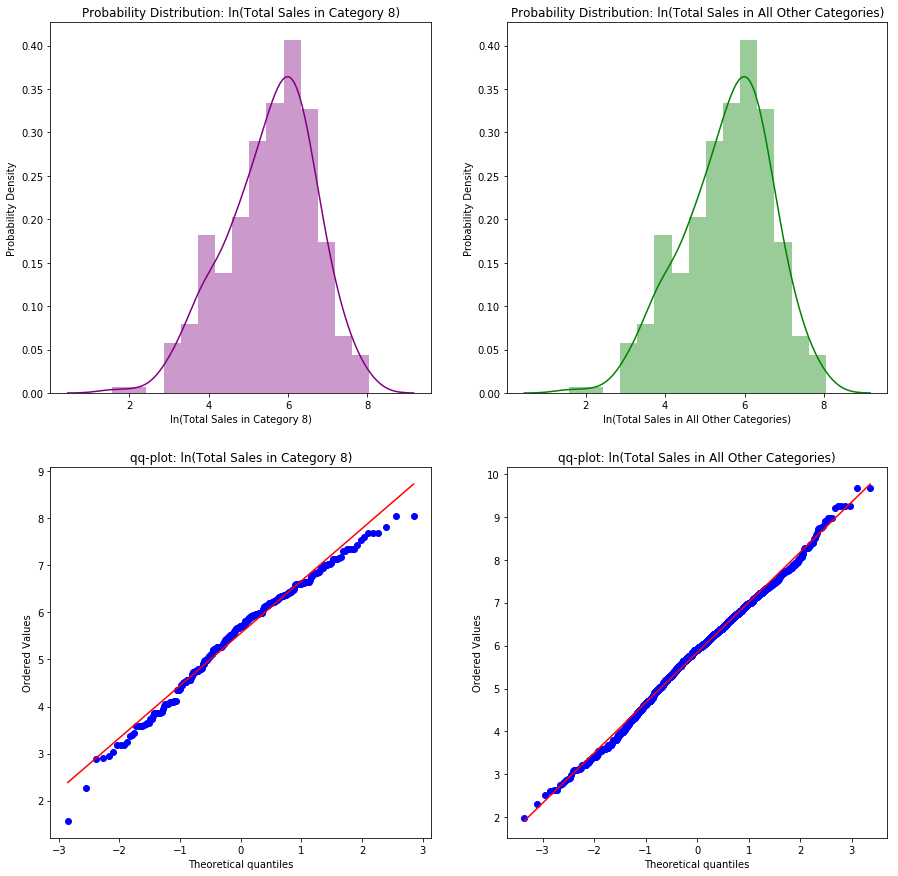

In [66]:
visualise_distributions(cat_8_sales['logSalesTotal'], all_other_sales['logSalesTotal'], 'ln(Total Sales in Category 8)', 
                        'ln(Total Sales in All Other Categories)')

The normality of the distribution is improved.  Alongside the central limit theorem, we can proceed with a t-test.  

In [67]:
hypothesis_t_test(cat_8_sales['logSalesTotal'], all_other_sales['logSalesTotal'], sample_size, sample_size, random_state=20)

'The t-statistic is -1.87 with a p-value of 0.07.  Since the p-value is greater than the cricital level of 0.05 the null hypothesis cannot be rejected'

The null hypothesis cannot be rejected.  There is insufficient evidence to suggest that mean sales for products in category 8 are lower than those in all other categories.

In [68]:
Cohen_d(cat_8_sales['logSalesTotal'], all_other_sales['logSalesTotal'])

Cohen's d is equal to -0.2.  The effect size is considered small


## Business Recommendations

To improve profitability, three recommendations can be made:

1. There is insufficient evidence to suggest that discounts increase mean order quantity or mean order value.  With this in mind, restrictions should be placed on the ability of the sales team to grant discounts.  This will lead to more products being sold at full price, thus improving profitability.
<br>

2. The performance of the UK sales team is significantly worse than that of the USA sales team.  Given that they are not generating sufficient sales to make a positive contribution to group profits, consideration should be given to:
    - Providing sales training.
    - Implementing rigorous sales targets.

    In the event that there is no improvement, it may be necessary to consider closing the UK sales office.  
<br>
3. No product rationalisation is currently required.  However, consideration could be given to reducing levels of stock held for slow-moving lines.  This will reduce the need for stock write-offs and improve profitability and cashflow.  

Together, these initiatives will help resolve the issue of declining profitability at Northwind.

## Future Work

To further this work:
- A more in depth study, at the product level, should be undertaken.  Each product may exhibit a different sensitivity to discounts.  
- If Northwind can provide additional detail on product cost, more indepth analysis can be done to identify low volume, low margin products.  This may lead to recommendations to reduce the size of the Northwind product portfolio.
- If Northwind can provide accurate information on employee start dates, the recommendations for the UK Sales Office can be updated.